<a href="https://colab.research.google.com/github/flych3r/IA025_2022S1/blob/main/ex06/matheus_xavier/IA025_A06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de uma CNN no CIFAR 10

In [1]:
nome = 'Matheus Xavier Sampaio - 220092'

print(f'Meu nome é {nome}')

Meu nome é Matheus Xavier Sampaio - 220092


Este exercicío consiste em implementar e treinar no CIFAR-10 vários blocos de uma Resnet seguido de uma camada linear de classificação.

## Importação das bibliotecas

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## Fixando as seeds

In [3]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [4]:
batch_size = 50

## Download do CIFAR-10

In [5]:
!mkdir -p ./data

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True,
    download=True, transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False,
    download=True, transform=transform
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Criação do dataloader

In [6]:
train_size = 40000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 800
Número de minibatches de validação: 200
Número de minibatches de teste: 200

Dimensões dos dados de um minibatch: torch.Size([50, 3, 32, 32])
Valores mínimo e máximo dos pixels:  tensor(-1.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Implementando o Bloco Básico da Resnet

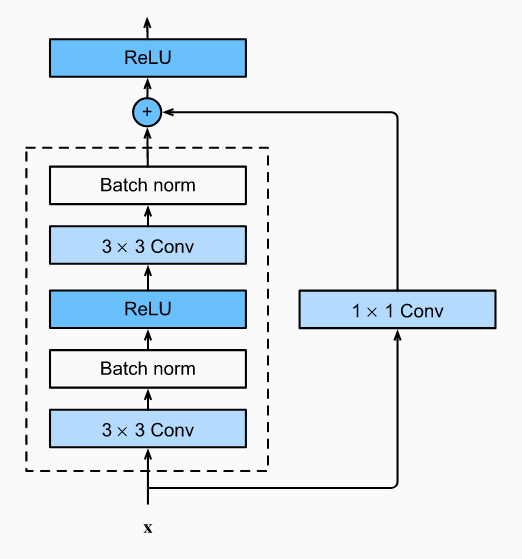

In [35]:
import torch.nn.functional as F
from torch import nn
from torch import Tensor


class MyBasicBlock(nn.Module):

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
    ) -> None:
        super().__init__()
        # Escreva seu código aqui.
        self.inplanes = inplanes
        self.planes = planes
        self.stride = stride

        self.conv1 = nn.Conv2d(
            self.inplanes, self.planes, kernel_size=3, 
            stride=self.stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(self.planes)

        self.conv2 = nn.Conv2d(
            self.planes, self.planes, kernel_size=3, 
            stride=1, padding=1, bias=False, 
        )
        self.bn2 = nn.BatchNorm2d(self.planes)

        self.downsample = nn.Conv2d(
            self.inplanes, self.planes, kernel_size=1,
            stride=self.stride, padding=0, bias=False,
            groups=1, dilation=1
        )


    def forward(self, x: Tensor) -> Tensor:
        # Escreva seu código aqui.
        out_skip = self.downsample(x)

        out_conv = self.conv1(x)
        out_conv = self.bn1(out_conv)
        out_conv = F.relu(out_conv)

        out_conv = self.conv2(out_conv)
        out_conv = self.bn2(out_conv)

        out = F.relu(out_conv + out_skip)

        return out

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [9]:
import torchvision

height_in = 5
width_in = 5
inplanes = 2
planes = 3
stride = 2

x = torch.rand(1, inplanes, height_in, width_in)

block = MyBasicBlock(inplanes=inplanes, planes=planes, stride=stride)

downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)

block_pt = torchvision.models.resnet.BasicBlock(inplanes=inplanes, planes=planes, stride=stride, downsample=downsample)

# Usa os mesmos pesos para minha implementação e a do pytorch
block.load_state_dict(block_pt.state_dict())

out = block(x)
target_out = block_pt(x)

print(f'out:\n{out}')
print(f'target_out:\n{target_out}')

assert torch.allclose(out, target_out, atol=1e-6)

out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)
target_out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)


## Modelo

Implemente um modelo de classificação que será treinado no CIFAR-10.

In [62]:
class MyResNetBlock(nn.Module):
    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
    ) -> None:
        super(MyResNetBlock, self).__init__()
        self.res1 = MyBasicBlock(inplanes, planes, stride)
        self.res2 = MyBasicBlock(planes, planes, 1)
    
    def forward(self, x):
        out = self.res1(x)
        return self.res2(out)


class Net(torch.nn.Module):
    def __init__(self, blocks, n_classes):
        super(Net, self).__init__()
        # Escreva seu código aqui.
        self.blocks = 4
        self.n_classes = n_classes

        planes = [2**(6 + i) for i in range(blocks)]
        inplanes = [3] + planes[:-1]
    
        self.residual_blocks = nn.Sequential(*[
            MyResNetBlock(i, p, 2)
            for i, p in zip(inplanes, planes)
        ])
        self.fc = nn.Linear(in_features=planes[-1], out_features=n_classes)

    def forward(self, x):
        # Escreva seu código aqui.
        out = self.residual_blocks(x)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, start_dim=1)
        out = self.fc(out)
        return out

## Treinamento

### Definição dos hiperparâmetros

In [63]:
n_epochs = 20
lr = 0.01

### Detectando a GPU

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [65]:
def evaluation(model, loader):
    # Escreva seu código aqui.
    correct_pred = []

    model.eval()
    for x, y in tqdm(loader, total=len(loader), desc='Evaluating'):
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        correct_pred.extend((outputs.argmax(dim=1) == y).tolist())

    mean_accuracy = np.mean(correct_pred)
    print(f'Accuracy: {mean_accuracy * 100:.2f}%')

### Laço de treinamento

In [67]:
from tqdm.auto import tqdm


model = Net(blocks=2, n_classes=10)

model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0

# Primeira avaliação com pesos aleatórios
evaluation(model=model, loader=val_dataloader)

for i in range(n_epochs):
    model.train()
    for x_train, y_train in tqdm(train_dataloader, total=len(train_dataloader), desc='Training'):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(train_dataset))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')

    # Chama a função de validação no final de cada época
    evaluation(model=model, loader=val_dataloader)

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 10.11%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 0/19 Loss: 1.5755690336227417


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 51.44%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 1/19 Loss: 1.4933176040649414


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 56.94%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 2/19 Loss: 0.949078381061554


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 64.84%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 3/19 Loss: 0.6832699775695801


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 67.89%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 4/19 Loss: 0.695962131023407


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 68.23%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 5/19 Loss: 0.7280352115631104


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 72.20%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 6/19 Loss: 0.6237952709197998


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 71.62%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 7/19 Loss: 0.622898280620575


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 65.79%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 8/19 Loss: 0.549608051776886


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 70.31%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 9/19 Loss: 0.39512884616851807


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 74.43%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 10/19 Loss: 0.35467278957366943


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 65.34%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 11/19 Loss: 0.2962190508842468


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 76.09%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 12/19 Loss: 0.19464576244354248


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 67.41%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 13/19 Loss: 0.30163463950157166


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 72.32%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 14/19 Loss: 0.21759453415870667


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 70.24%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 15/19 Loss: 0.12938034534454346


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 73.23%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 16/19 Loss: 0.05811551958322525


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 75.51%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 17/19 Loss: 0.06993177533149719


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 73.72%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 18/19 Loss: 0.10174474865198135


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 71.05%


Training:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 19/19 Loss: 0.0724683552980423


Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 74.28%


### Visualização usual da perda, somente no final de cada minibatch

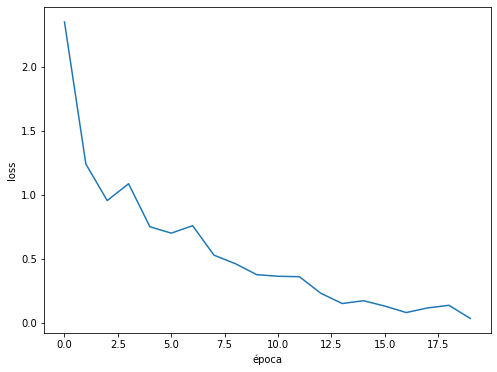

In [68]:
n_batches_train = len(train_dataloader)
plt.figure(figsize=(8, 6))
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')
plt.ylabel('loss')
plt.show()

## Avaliação final no dataset de testes

In [69]:
evaluation(model=model, loader=test_dataloader)

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 74.75%


# Bonus Opcional

## Implementando o Dropout

In [70]:
class MyDropout(torch.nn.Module):
    def __init__(self, p: float):
        # Escreva seu código aqui.
        super(MyDropout, self).__init__()
        self.p = p

    def forward(self, x: Tensor, training: bool):
        # Escreva seu código aqui.
        if not training:
            return x
        out = x * (torch.rand_like(x) > self.p)
        return out

## Mostre que sua implementação traz resultados semelhantes à implementação do pytorch

In [71]:
import math

p = 0.25
dropout = MyDropout(p=p)

x = torch.rand(16, 3, 32, 32)

out = dropout(x, training=True)
out_pt = torch.nn.functional.dropout(x, p=p, training=True)

mean_zeros = (out == 0).sum() / out.numel()
mean_zeros_pt = (out_pt == 0).sum() / out_pt.numel()

print(f'mean zeros: {mean_zeros}')
print(f'mean zeros pytorch: {mean_zeros_pt}')

assert math.isclose(mean_zeros, mean_zeros_pt, abs_tol=1e-2)

out = dropout(x, training=False)
target_out = torch.nn.functional.dropout(x, p=p, training=False, inplace=False)
assert torch.allclose(out, target_out, atol=1e-6)

mean zeros: 0.2483927458524704
mean zeros pytorch: 0.2490641325712204
